<a href="https://colab.research.google.com/github/Strojove-uceni/final-projects-i_am_not_a_robot/blob/main/captcha_model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install and load packages
! pip install patool
! pip install pyunpack
! pip install captcha

import argparse
import os
import random
import requests
import zipfile
import errno
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pyunpack import Archive
import glob
import string
from PIL import Image
from tqdm import tqdm
import torch.nn.functional 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from captcha.image import ImageCaptcha
import string
import random


     |████████████████████████████████| 77 kB 3.0 MB/s 
     |████████████████████████████████| 101 kB 3.5 MB/s 


In [ ]:
# connect to google drive for saving models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

n_cudas = torch.cuda.device_count()

print(f'We are now using {device}. There are {n_cudas} available gpus.')

if torch.cuda.is_available():
    print(f'{torch.cuda.get_device_name(0)}')

We are now using cuda. There are 1 available gpus.
Tesla K80


# Data preprocessing

In [ ]:
# new
# download files from google drive

# load test data
!gdown --id 1-74h6oEnYm_8uCDrDNvyO2iy_LSSlLsi

! mkdir 'test'

Archive('captcha_test.tar.gz').extractall('test')

test_labels = os.listdir('test/test')
print('test files:', len(test_labels))

Downloading...
From: https://drive.google.com/uc?id=1-74h6oEnYm_8uCDrDNvyO2iy_LSSlLsi
To: /content/captcha_test.tar.gz
100% 470M/470M [00:06<00:00, 74.9MB/s]
test files: 50000


In [ ]:
# def code_generator(size=6, chars=string.ascii_uppercase + string.ascii_lowercase + string.digits):
def code_generator(size=6, chars=string.ascii_lowercase + string.digits):
    """ Generates alphanumerical code of given length """
    return ''.join(random.choice(chars) for _ in range(size))

## Create Data Loader

In [ ]:
workers = 2                           # worker threads for loading the data with the DataLoader
batch_size = 512                      # size of batch
image_size = [60, 180]                # size of imput images
nc = 3                                # number of color channels in the input images

# normalization parameters
normalize_mean = (0.485, 0.456, 0.406)
normalize_std = (0.229, 0.224, 0.225)

# for reproducibility
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

captcha_len = 6

In [ ]:
class Custom_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, data_dir, data_labels):
        self.data_dir = data_dir
        self.data_labels = data_labels
        
    def __len__(self):
        return len(self.data_labels)
    
    def __getitem__(self, index):
        image_label = self.data_labels[index]
        image_fp = os.path.join(self.data_dir, image_label)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_label.split(".")[0]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ])
        return transform_ops(image)

In [ ]:
# decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def UnNormalizeBatch(batch):
    for i in range(batch.shape[3]):
       batch[:,:,:,i] = (batch[:,:,:,i] * normalize_std[i]) + normalize_mean[i]

    return batch

# Creating model

In [ ]:
# these are all symbols the captchas will have
symbols = string.ascii_uppercase + string.ascii_lowercase + string.digits  
symbols_char = {k:v for k,v in enumerate(symbols, start=0)}
symbols_idx = {v:k for k,v in symbols_char.items()}
num_symbols = len(symbols_idx)

## Define model with resnet 18

In [ ]:
rnn_hidden_size = 256

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
class CTC(nn.Module):
    
    def __init__(self, num_symbols, rnn_hidden_size=256, dropout=0.1):
        
        super(CTC, self).__init__()
        self.num_chars = num_symbols
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2 - for resnet18
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)

        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_symbols)
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
ctc = CTC(num_symbols, rnn_hidden_size=rnn_hidden_size)
ctc.apply(weights_init)
ctc = ctc.to(device)

In [ ]:
ctc

CTC(
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

## Define loss

In [ ]:
criterion = nn.CTCLoss(blank=0)

In [ ]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [symbols_idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [ ]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = torch.nn.functional.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

# Save checkpoint function

In [ ]:
def save_checkpoint(n_epochs, model, optimizer, losses, version = 0):
    checkpoint = {'epoch': n_epochs,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'loss': losses}

    torch.save(checkpoint, '/content/drive/MyDrive/Colab Notebooks/01SU2/CAPTCHA/final_model_7_checkpoint_{}.pth'.format(version))

## Train model

In [ ]:
num_epochs = 4
lr = 0.001
weight_decay = 1e-3
clip_norm = 8

n_generating = 8
! mkdir 'train'
! mkdir 'train/train'

In [ ]:
optimizer = optim.Adam(ctc.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [ ]:
ctc = CTC(num_symbols, rnn_hidden_size=rnn_hidden_size)
ctc.apply(weights_init)
ctc = ctc.to(device)

In [ ]:
# load checkpoint - run when continue training

checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/01SU2/CAPTCHA/final_model_7_checkpoint_32.pth')

ctc.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

num_updates_epochs = checkpoint['epoch']
epoch_losses = checkpoint['loss']

iteration_losses = []

ctc.train() # always use TRAIN for resuming training

version_of_model = 33

In [ ]:
# run when starting new training
epoch_losses = []
iteration_losses = []
num_updates_epochs = []

version_of_model = 1


In [ ]:
# train with new data every couple of iteration

# inicialize CAPTCHA with custom fonts:
fonts = ['/content/drive/MyDrive/Colab Notebooks/01SU2/CAPTCHA/fonts/calibri.ttf',
         '/content/drive/MyDrive/Colab Notebooks/01SU2/CAPTCHA/fonts/times.ttf',
         '/content/drive/MyDrive/Colab Notebooks/01SU2/CAPTCHA/fonts/arial.ttf']
image = ImageCaptcha(width = 180, height = 80, fonts = fonts) 

N = 100000                      # number of generated codes

for generation in range(n_generating):

    !rm -rf train
    ! mkdir 'train'
    ! mkdir 'train/train'

    # generate captcha codes
    for i in tqdm(range(N)):
        label = code_generator(captcha_len)
        # save in separate png files:
        image.write(label,'train/train/{}.png'.format(label))

    train_labels = os.listdir('train/train')

    dataset_train = Custom_Dataset('train/train', train_labels) 

    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, num_workers=workers, shuffle=True)

    help_const = 0

    for epoch in tqdm(range(1, num_epochs+1)):
        epoch_loss_list = [] 
        num_updates_epoch = 0
        for image_batch, text_batch in train_loader:
            optimizer.zero_grad()
            text_batch_logits = ctc(image_batch.to(device))
            loss = compute_loss(text_batch, text_batch_logits)
            iteration_loss = loss.item()

            if np.isnan(iteration_loss) or np.isinf(iteration_loss):
                continue
              
            num_updates_epoch += 1
            iteration_losses.append(iteration_loss)
            epoch_loss_list.append(iteration_loss)
            loss.backward()
            nn.utils.clip_grad_norm_(ctc.parameters(), clip_norm)
            optimizer.step()

            help_const = help_const + 1
            if (help_const % 50 == 0):
                print("Batch:{}    Loss:{}".format(help_const, np.mean(epoch_loss_list)))

        epoch_loss = np.mean(epoch_loss_list)
        print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
        epoch_losses.append(epoch_loss)
        num_updates_epochs.append(num_updates_epoch)
        lr_scheduler.step(epoch_loss)

        save_checkpoint(num_updates_epochs, ctc, optimizer, epoch_losses, version_of_model)
        version_of_model = version_of_model + 1

        help_const = 0

    print('\n GENERATION: {} \n'.format(generation))


  0%|          | 0/4 [00:00<?, ?it/s]

Batch:50    Loss:4.161618657112122
Batch:100    Loss:3.8808073878288267
Batch:150    Loss:3.5590595483779905
Epoch:1    Loss:3.312900805959896    NumUpdates:196


 25%|██▌       | 1/4 [04:22<13:08, 262.68s/it]

Batch:50    Loss:2.3362789869308473
Batch:100    Loss:2.2606256771087647
Batch:150    Loss:2.212877599398295
Epoch:2    Loss:2.1789122527959397    NumUpdates:196


 50%|█████     | 2/4 [08:45<08:44, 262.48s/it]

Batch:50    Loss:2.0341687774658204
Batch:100    Loss:2.0132523906230926
Batch:150    Loss:1.996072280406952
Epoch:3    Loss:1.9838637904245027    NumUpdates:196


 75%|███████▌  | 3/4 [13:07<04:22, 262.69s/it]

Batch:50    Loss:1.974479615688324
Batch:100    Loss:1.933497896194458
Batch:150    Loss:1.9174854556719463
Epoch:4    Loss:1.908645280769893    NumUpdates:196


100%|██████████| 4/4 [17:31<00:00, 262.82s/it]



 GENERATION: 0 



  0%|          | 0/4 [00:00<?, ?it/s]

Batch:50    Loss:1.917186851501465
Batch:100    Loss:1.8856223356723785
Batch:150    Loss:1.8752219287554424
Epoch:1    Loss:1.871935253848835    NumUpdates:196


 25%|██▌       | 1/4 [04:22<13:08, 262.68s/it]

Batch:50    Loss:1.8476201748847962
Batch:100    Loss:1.8322627079486846
Batch:150    Loss:1.8281015865008037
Epoch:2    Loss:1.8238538083981495    NumUpdates:196


 50%|█████     | 2/4 [08:45<08:45, 262.93s/it]

Batch:50    Loss:1.8063546538352966
Batch:100    Loss:1.8004949808120727
Batch:150    Loss:1.8004663372039795
Epoch:3    Loss:1.7981483808585577    NumUpdates:196


 75%|███████▌  | 3/4 [13:09<04:23, 263.07s/it]

Batch:50    Loss:1.8982310438156127
Batch:100    Loss:1.8395200657844544
Batch:150    Loss:1.8157100145022074
Epoch:4    Loss:1.8020513179350872    NumUpdates:196


100%|██████████| 4/4 [17:31<00:00, 262.93s/it]



 GENERATION: 1 



  0%|          | 0/4 [00:00<?, ?it/s]

Batch:50    Loss:1.7890485882759095
Batch:100    Loss:1.7725994884967804
Batch:150    Loss:1.765344557762146
Epoch:1    Loss:1.7614600786140986    NumUpdates:196


 25%|██▌       | 1/4 [04:23<13:09, 263.07s/it]

Batch:50    Loss:1.7927811765670776
Batch:100    Loss:1.7657584810256959
Batch:150    Loss:1.7559511987368266
Epoch:2    Loss:1.7491102133478438    NumUpdates:196


 50%|█████     | 2/4 [08:45<08:45, 262.98s/it]

Batch:50    Loss:1.7325407719612123
Batch:100    Loss:1.7244958925247191
Batch:150    Loss:1.7224806467692058
Epoch:3    Loss:1.7205016728566618    NumUpdates:196


 75%|███████▌  | 3/4 [13:08<04:22, 262.86s/it]

Batch:50    Loss:1.723230459690094
Batch:100    Loss:1.7144581365585327
Batch:150    Loss:1.7136588350931803
Epoch:4    Loss:1.7171435733230747    NumUpdates:196


100%|██████████| 4/4 [17:31<00:00, 262.76s/it]



 GENERATION: 2 



  0%|          | 0/4 [00:00<?, ?it/s]

Batch:50    Loss:1.7570048093795776
Batch:100    Loss:1.745176784992218
Batch:150    Loss:1.7323874640464783
Epoch:1    Loss:1.7302536064264726    NumUpdates:196


 25%|██▌       | 1/4 [04:21<13:05, 261.71s/it]

Batch:50    Loss:1.7378915309906007
Batch:100    Loss:1.715721687078476
Batch:150    Loss:1.711082162062327
Epoch:2    Loss:1.7103958482644996    NumUpdates:196


 50%|█████     | 2/4 [08:43<08:43, 261.95s/it]

Batch:50    Loss:1.719812684059143
Batch:100    Loss:1.7053256392478944
Batch:150    Loss:1.7055106242497762
Epoch:3    Loss:1.7024180834390679    NumUpdates:196


 75%|███████▌  | 3/4 [13:06<04:22, 262.37s/it]

Batch:50    Loss:1.71911536693573
Batch:100    Loss:1.7061150193214416
Batch:150    Loss:1.7011208573977152
Epoch:4    Loss:1.6992411011335802    NumUpdates:196


100%|██████████| 4/4 [17:29<00:00, 262.36s/it]



 GENERATION: 3 



  0%|          | 0/4 [00:00<?, ?it/s]

Batch:50    Loss:1.7420431661605835
Batch:100    Loss:1.724469940662384
Batch:150    Loss:1.7154380035400392
Epoch:1    Loss:1.7159215449070444    NumUpdates:196


 25%|██▌       | 1/4 [04:22<13:07, 262.63s/it]

Batch:50    Loss:1.7210003685951234
Batch:100    Loss:1.704667594432831
Batch:150    Loss:1.700545888741811
Epoch:2    Loss:1.6971072366043014    NumUpdates:196


 50%|█████     | 2/4 [08:45<08:45, 262.77s/it]

Batch:50    Loss:1.6937019109725953
Batch:100    Loss:1.6910976576805115
Batch:150    Loss:1.6887532726923624
Epoch:3    Loss:1.6872964264178762    NumUpdates:196


 75%|███████▌  | 3/4 [13:08<04:22, 262.88s/it]

Batch:50    Loss:1.6996954250335694
Batch:100    Loss:1.692477548122406
Batch:150    Loss:1.6883687178293865
Epoch:4    Loss:1.6889746493222761    NumUpdates:196


100%|██████████| 4/4 [17:30<00:00, 262.63s/it]



 GENERATION: 4 



  0%|          | 0/4 [00:00<?, ?it/s]

Batch:50    Loss:1.7278195095062256
Batch:100    Loss:1.7121091973781586
Batch:150    Loss:1.702640832265218
Epoch:1    Loss:1.6992414289591264    NumUpdates:196


 25%|██▌       | 1/4 [04:22<13:07, 262.53s/it]

Batch:50    Loss:1.685750207901001
Batch:100    Loss:1.679483196735382
Batch:150    Loss:1.6806453959147136
Epoch:2    Loss:1.6805991603403676    NumUpdates:196


 50%|█████     | 2/4 [08:44<08:44, 262.12s/it]

Batch:50    Loss:1.7030955862998962
Batch:100    Loss:1.685194284915924
Batch:150    Loss:1.6830695788065593
Epoch:3    Loss:1.6821831750626466    NumUpdates:196


 75%|███████▌  | 3/4 [13:06<04:22, 262.33s/it]

Batch:50    Loss:1.6794886112213134
Batch:100    Loss:1.676500941514969
Batch:150    Loss:1.6783386985460917
Epoch:4    Loss:1.6790597669932308    NumUpdates:196


100%|██████████| 4/4 [17:29<00:00, 262.42s/it]



 GENERATION: 5 



  0%|          | 0/4 [00:00<?, ?it/s]

Batch:50    Loss:1.7151965641975402
Batch:100    Loss:1.7035944521427155
Batch:150    Loss:1.7011944309870402
Epoch:1    Loss:1.697953260066558    NumUpdates:196


 25%|██▌       | 1/4 [04:22<13:06, 262.26s/it]

Batch:50    Loss:1.7014563035964967
Batch:100    Loss:1.6868490386009216
Batch:150    Loss:1.679487164815267
Epoch:2    Loss:1.6787361636453746    NumUpdates:196


 50%|█████     | 2/4 [08:44<08:44, 262.16s/it]

Batch:50    Loss:1.71628915309906
Batch:100    Loss:1.6937440025806427
Batch:150    Loss:1.6862317140897114
Epoch:3    Loss:1.6847281133642003    NumUpdates:196


 75%|███████▌  | 3/4 [13:07<04:22, 262.46s/it]

Batch:50    Loss:1.75968608379364
Batch:100    Loss:1.7201314043998719
Batch:150    Loss:1.7028067795435589
Epoch:4    Loss:1.696509210430846    NumUpdates:196


100%|██████████| 4/4 [17:29<00:00, 262.39s/it]



 GENERATION: 6 



  0%|          | 0/4 [00:00<?, ?it/s]

Batch:50    Loss:1.7052252650260926
Batch:100    Loss:1.6920653212070464
Batch:150    Loss:1.687820025285085
Epoch:1    Loss:1.6852701586119982    NumUpdates:196


 25%|██▌       | 1/4 [04:22<13:06, 262.25s/it]

Batch:50    Loss:1.6673116540908814
Batch:100    Loss:1.66693088889122
Batch:150    Loss:1.6696857325236003
Epoch:2    Loss:1.6723813876813771    NumUpdates:196


 50%|█████     | 2/4 [08:44<08:44, 262.22s/it]

Batch:50    Loss:1.6856003165245057
Batch:100    Loss:1.6782855021953582
Batch:150    Loss:1.6736030220985412
Epoch:3    Loss:1.673546974148069    NumUpdates:196


 75%|███████▌  | 3/4 [13:07<04:22, 262.50s/it]

Batch:50    Loss:1.6968598365783691
Batch:100    Loss:1.6770391869544983
Batch:150    Loss:1.67269877910614
Epoch:4    Loss:1.670483372649368    NumUpdates:196


100%|██████████| 4/4 [17:29<00:00, 262.27s/it]


 GENERATION: 7 



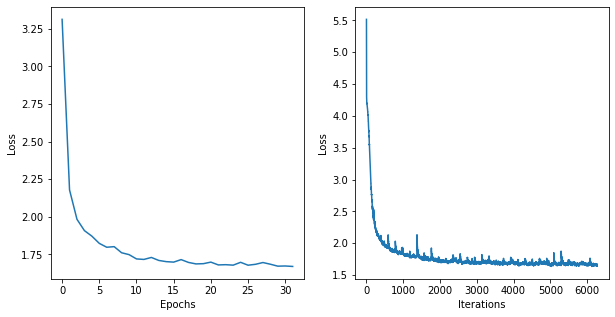

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

Two times longer train - loss function dropped to 1.5237 -> model_final_7

## Save model

In [ ]:
PATH = "/content/drive/MyDrive/Colab Notebooks/01SU2/CAPTCHA/model_final_7.pt"
torch.save(ctc.state_dict(), PATH)

## Load model

In [ ]:
PATH = "/content/drive/MyDrive/Colab Notebooks/01SU2/CAPTCHA/model_final_7.pt"

ctc = CTC(num_symbols, rnn_hidden_size=rnn_hidden_size)
ctc.apply(weights_init)
ctc = ctc.to(device)

ctc.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Make predictions

In [ ]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = torch.nn.functional.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [symbols_char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [ ]:
test_labels = os.listdir('test/test')
dataset_test = Custom_Dataset('test/test', test_labels)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, num_workers=workers, shuffle=True)

results_test = pd.DataFrame(columns=['actual', 'prediction'])
# test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = ctc(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

100%|██████████| 98/98 [01:11<00:00,  1.37it/s]


In [ ]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [ ]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,fmwxm9,fmmwxxm99,fmwxm9
1,q97ld2,q9977ld22,q97ld2
2,9t3npk,99t3nppkk,9t3npk
3,ig0dm6,igg0ddmm6,ig0dm6
4,kzapsw,kzaapssww,kzapsw


# Evaluate model

In [ ]:
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print('Test accuracy: ', test_accuracy)

Test accuracy:  0.90398


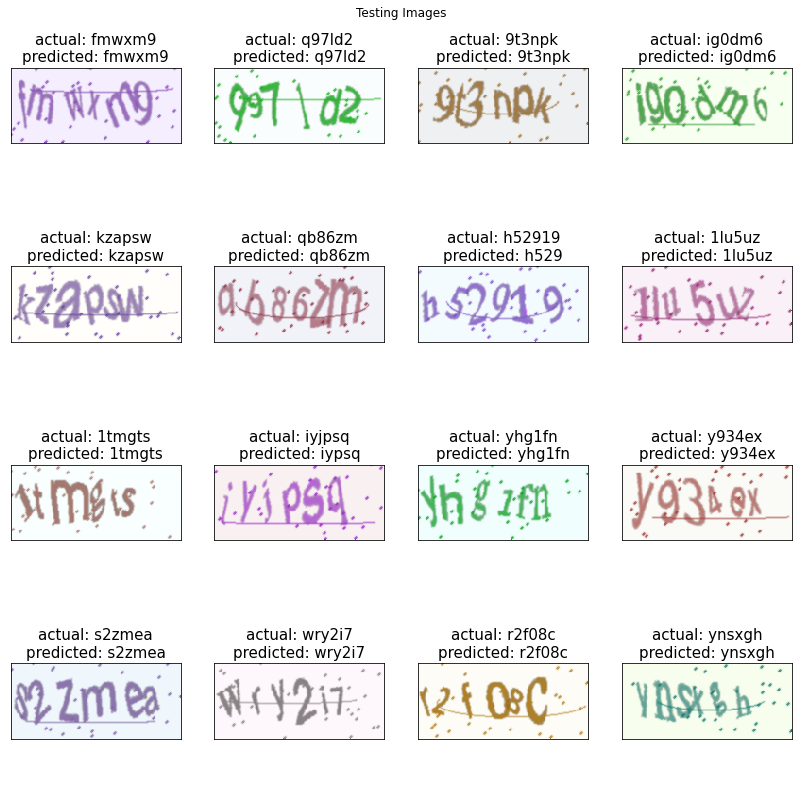

In [ ]:
# view some test images and predictions

fig = plt.figure(figsize=(14,14))
plt.axis("off")
plt.title("Testing Images")

for i in range(16):
    result = results_test.iloc[i]
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    img = mpimg.imread('test/test/{}.png'.format(result[0]))
    ax.imshow(img, interpolation='nearest')
    plt.title('actual: ' + result[0] + '\n' + 'predicted: ' + result[2], color='k', fontsize=15)